In [1]:
#!pip install category_encoders
#!pip install imblearn
#!pip install pandas==0.23.4

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
from scipy import interp

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline,Pipeline,FeatureUnion
import category_encoders
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN,BorderlineSMOTE,SMOTENC
from imblearn.pipeline import make_pipeline as imb_mp
from imblearn.pipeline import Pipeline as imb_p
from collections import Counter


from itertools import cycle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold,RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD



%matplotlib inline

### Постановка задачи и описание данных:

Описание переменных и датасет взяты с сайта: http://archive.ics.uci.edu/ml/datasets/thyroid+disease

Этот набор данных содержит информацию о заболевании - Гипотиреоз. 

Болезнь характеризуется сниженим функции щитовидной железы.

Данные собраны Garvan Institue в Австралии.

Объекты поделены на 5 классов, 29 атрибутов (22 категориальных и 7 численных).


Сами данные описаны следующим образом:
- age:				continuous.
- sex:				M, F.
- on thyroxine:			f, t.
- query on thyroxine:		f, t.
- on antithyroid medication:	f, t.
- sick:				f, t.
- pregnant:			f, t.
- thyroid surgery:		f, t.
- I131 treatment:			f, t.
- query hypothyroid:		f, t.
- query hyperthyroid:		f, t.
- lithium:			f, t.
- goitre:				f, t.
- tumor:				f, t.
- hypopituitary:			f, t.
- psych:				f, t.
- TSH measured:			f, t.
- TSH:				continuous.
- T3 measured:			f, t.
- T3:				continuous.
- TT4 measured:			f, t.
- TT4:				continuous.
- T4U measured:			f, t.
- T4U:				continuous.
- FTI measured:			f, t.
- FTI:				continuous.
- TBG measured:			f, t.
- TBG:				continuous.
- referral_source WEST, STMW, SVHC, SVI, SVHD, other.
- class


Целевая переменная - Class.

### EDA.

Загрузим датасет.

В описании сказано, что данные, которые содержат знак '?' - это пропущенные значения, поэтому сразу укажем это при считывании данных.

Исходно это сформулировано так: several missing attribute values (signified by "?").

In [3]:
df = pd.read_csv('data/dataset_57_hypothyroid.csv', sep = ',',na_values = '?',decimal=".")
#df = pd.read_csv('https://raw.githubusercontent.com/DSmentor/EPAM_SPb_DS_course_files/master/3.Classification_1/dataset_57_hypothyroid.csv', 
#                 sep = ',',na_values = '?',decimal=".")

In [4]:
df.shape

(3772, 30)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
age                          3771 non-null float64
sex                          3622 non-null object
on_thyroxine                 3772 non-null object
query_on_thyroxine           3772 non-null object
on_antithyroid_medication    3772 non-null object
sick                         3772 non-null object
pregnant                     3772 non-null object
thyroid_surgery              3772 non-null object
I131_treatment               3772 non-null object
query_hypothyroid            3772 non-null object
query_hyperthyroid           3772 non-null object
lithium                      3772 non-null object
goitre                       3772 non-null object
tumor                        3772 non-null object
hypopituitary                3772 non-null object
psych                        3772 non-null object
TSH_measured                 3772 non-null object
TSH                          3403 non-null

In [6]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [7]:
df.tail()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
3767,30.0,F,f,f,f,f,f,f,f,f,...,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,...,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,...,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,...,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative
3771,64.0,F,f,f,f,f,f,f,f,f,...,t,99.0,t,1.07,t,92.0,f,NaN,other,negative


Также посмотрим какие значения содержит целевая переменная:

In [8]:
df.Class.unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

Итого: есть набор данных из 30 колонов и 3772 строк, различных типов.
Наш датасет содержит в себе сразу трейн/тест выборки:  2800 instances in each data set, 972 instances in each test set.

Часть данных - это бинарные признаки (true/false, male/female), другая часть - это численные значения, а также еще есть  referral_source (WEST, STMW, SVHC, SVI, SVHD, other).

Целевая переменная Class состоит из следующих значений: ('negative', 'compensated_hypothyroid', 'primary_hypothyroid',
'secondary_hypothyroid')

Перед тем, как приступать к каким-либо преобразованиям требуется убедиться, в каких объемах есть пропуски и остались ли значения помеченные знаком '?':

Первым делом, проверим, что знаки ? пропали из набора данных.

In [9]:
df.eq('?').sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH_measured                 0
TSH                          0
T3_measured                  0
T3                           0
TT4_measured                 0
TT4                          0
T4U_measured                 0
T4U                          0
FTI_measured                 0
FTI                          0
TBG_measured                 0
TBG                          0
referral_source              0
Class                        0
dtype: int64

Таких значений не оказалось, поэтому идём далее.

Проверим, какая часть данных отсутствует, для этого выведем долю и количество пропущенных значений:

In [10]:
print (pd.concat([1- df.count() / df.shape[0], df.isna().sum()],axis=1))

                                  0     1
age                        0.000265     1
sex                        0.039767   150
on_thyroxine               0.000000     0
query_on_thyroxine         0.000000     0
on_antithyroid_medication  0.000000     0
sick                       0.000000     0
pregnant                   0.000000     0
thyroid_surgery            0.000000     0
I131_treatment             0.000000     0
query_hypothyroid          0.000000     0
query_hyperthyroid         0.000000     0
lithium                    0.000000     0
goitre                     0.000000     0
tumor                      0.000000     0
hypopituitary              0.000000     0
psych                      0.000000     0
TSH_measured               0.000000     0
TSH                        0.097826   369
T3_measured                0.000000     0
T3                         0.203871   769
TT4_measured               0.000000     0
TT4                        0.061241   231
T4U_measured               0.00000

Столбец TBG состоит из пропусков полностью, поэтому его придется дропнуть.

В остальных столбцах процент пропусков не превышает 20%, что достаточно неплохо и с этим нужно работать.

Удалим TBG, т.к. он не содержит значений вообще.

In [11]:
df.drop('TBG',axis=1,inplace=True)

Исследуем величины, в которых содержаться пропуски, для того, чтобы определиться с тем, будем ли мы их заполнять/чем будем заполнять.

In [12]:
col_with_na = df.columns[df.isna().sum() > 0 ]
col_with_na

Index(['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'], dtype='object')

Так как 6 из 7 признаков - численные, то графики в данном случае строить смысла нет, чтобы не дублировать вывод одной и той же информации. Численные признаки будут рассматриваться далее.

Для полов построим отдельно гистограмму. В целом, для анализа пропусков этот график не имеет смысла (т.к отствует только 1 значение), но посмотреть на это соотношение стоит, т.к. его можно будет попробовать использовать для дальнейшего анализа при работе с признаками.

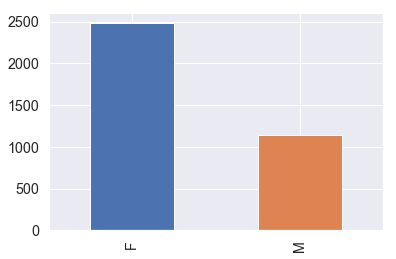

In [13]:
df['sex'].value_counts().plot(kind='bar')

Как оказалось, женщин в выборке в два раза больше, что говорит о дисбалансе в этом признаке.

Зафиксируем целевую переменную а также, выделим числовые и категориальные признаки в отдельные наборы данных.

In [14]:
target = 'Class'
seed = 10
df_num = df.select_dtypes(include=['float64'])
df_cat = df.select_dtypes(include=['object'])

Приступим к анализу численных признаков.

Выведем численные статистики.

In [15]:
df_num.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


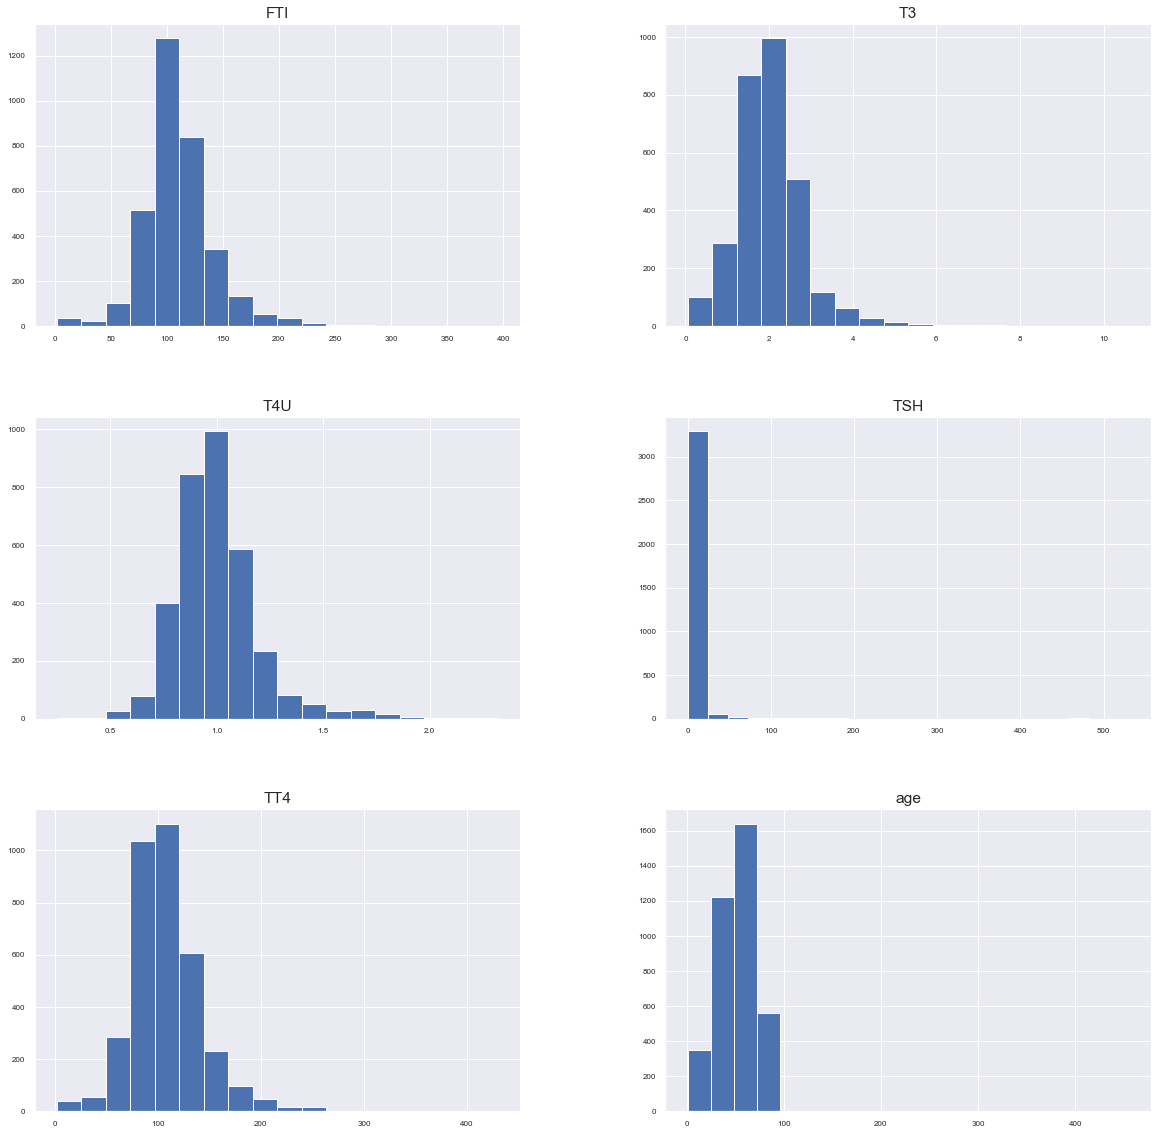

In [16]:
df_num.hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

Вывод: 

Скорее всего выбросы есть в: 
- Age , т.к. не может быть возраст 495 (возможно такое и бывает, но из моего опыта, такое невозможно)
- TSH, TT4, FTI т.к.  максимальные значения этих величин выше 75 процентов данных. - эти величины обозначают количество гормонов в крови.

Удалим выброс в Age, т.к. скорее всего это ошибка ввода.

Можно конечно предположить, что человек хотел ввести, 45.5 или 55 и заменить на выбранное число, но так делать некорректно, по отношению к данным.

Проверим значение данного выброса:

In [17]:
df_num[df_num.age > 100]

,age,TSH,T3,TT4,T4U,FTI
1364,455.0,1.1,2.0,118.0,1.13,104.0


In [18]:
df_cat[df_cat.index == 1364]

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured,referral_source,Class
1364,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,SVI,negative


In [19]:
df_num.drop(index=1364, inplace=True)
df_cat.drop(index=1364, inplace=True)
#сразу обновим индексы
df_num.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)

E:\Python\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Рассмотрим величину TSH.

In [20]:
ind_tsh = df_num[df_num.TSH > 300].index
df_num[df_num.TSH > 300]

,age,TSH,T3,TT4,T4U,FTI
1165,18.0,478.0,NaN,45.0,1.30,34.0
2506,2.0,472.0,1.7,34.0,1.17,29.0
2771,25.0,468.0,0.7,21.0,1.10,19.0
3426,18.0,440.0,0.5,24.0,1.32,18.0
3448,59.0,530.0,2.0,10.0,1.12,8.5
3638,60.0,400.0,0.5,11.0,1.19,9.1


In [21]:
df_cat.iloc[ind_tsh,:]

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured,referral_source,Class
1165,F,t,f,f,f,f,f,f,f,f,...,f,f,t,f,t,t,t,f,other,primary_hypothyroid
2506,NaN,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,STMW,primary_hypothyroid
2771,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid
3426,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid
3448,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid
3638,F,t,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid


Это не является выбросом, такой вывод сделан из анализа предметной области, высокий уровень TSH говорит об ослабленной щитовидной железе, что подтверждается значением переменной класс.

FTI и TT4 будем рассматривать совместно, т.к. они взаимосвязаны.

In [22]:
ind_TT4_FTI = df_num[(df_num.TT4 > 250) & (df_num.FTI > 250)].index
df_num.iloc[ind_TT4_FTI,:]

,age,TSH,T3,TT4,T4U,FTI
604,27.0,0.020,5.3,272.0,0.97,281.0
743,41.0,0.150,7.3,430.0,1.09,395.0
1414,41.0,0.200,NaN,430.0,1.09,395.0
2994,58.0,0.200,NaN,256.0,0.90,283.0
3257,59.0,0.025,5.7,372.0,1.27,291.0


In [23]:
df_cat.iloc[ind_TT4_FTI,:]

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured,referral_source,Class
604,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,negative
743,F,f,f,f,f,f,f,f,f,t,...,f,f,t,t,t,t,t,f,STMW,negative
1414,F,f,f,f,f,t,f,f,f,t,...,f,f,t,f,t,t,t,f,STMW,negative
2994,F,f,f,f,f,f,f,f,t,t,...,f,f,t,f,t,t,t,f,other,negative
3257,F,t,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,SVHD,negative


Исходя из предметной области, эти величины TT4 и FTI связаны между собой, the Free Thyroxine Index (FTI or T7) is obtained by multiplying the total T4 with T3 uptake.

В нашем случае T3 не uptake, но взаимосвязь прослеживается.

Рассмотрим корреляции между численными величинами:

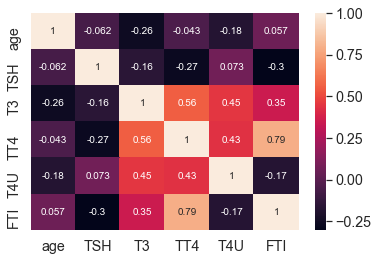

In [24]:
corr = df_num.corr()
sns.heatmap(corr, annot=True);

Выделяются две корреляции:
- T3 и TT4
- TT4 и FTI

Возможно, если мы оставим только TT4 (уберем T3 и FTI), это поможет улучшить обучающую способность модели.
Это проверю при работе с фичами.
Также, исходя из анализа предметной области: FTI = Thyroxine (T4)/Thyroid Binding Capacity.

Для построения baseline выберем медиану для заполнения пропусков, т.к. в данном случае среднее даст слишком большое смещение.

Посмотрим на категориальные признаки.

Перед тем, как приступать к анализу категориальных признаков столбцы  'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured' дропнем, т.к. они представляют собой индикатор, было ли собрано соотвествующее численнное значение.

In [25]:
df_cat.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured' ], axis = 1, inplace=True)

E:\Python\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [26]:
for i, col in enumerate(df_cat.columns[:-1]):
    print(df_cat[col].value_counts())

F    2479
M    1142
Name: sex, dtype: int64
f    3307
t     464
Name: on_thyroxine, dtype: int64
f    3721
t      50
Name: query_on_thyroxine, dtype: int64
f    3728
t      43
Name: on_antithyroid_medication, dtype: int64
f    3624
t     147
Name: sick, dtype: int64
f    3718
t      53
Name: pregnant, dtype: int64
f    3718
t      53
Name: thyroid_surgery, dtype: int64
f    3712
t      59
Name: I131_treatment, dtype: int64
f    3537
t     234
Name: query_hypothyroid, dtype: int64
f    3534
t     237
Name: query_hyperthyroid, dtype: int64
f    3753
t      18
Name: lithium, dtype: int64
f    3737
t      34
Name: goitre, dtype: int64
f    3675
t      96
Name: tumor, dtype: int64
f    3770
t       1
Name: hypopituitary, dtype: int64
f    3587
t     184
Name: psych, dtype: int64
f    3771
Name: TBG_measured, dtype: int64
other    2201
SVI      1033
SVHC      386
STMW      112
SVHD       39
Name: referral_source, dtype: int64


Продублируем таблицу графически:

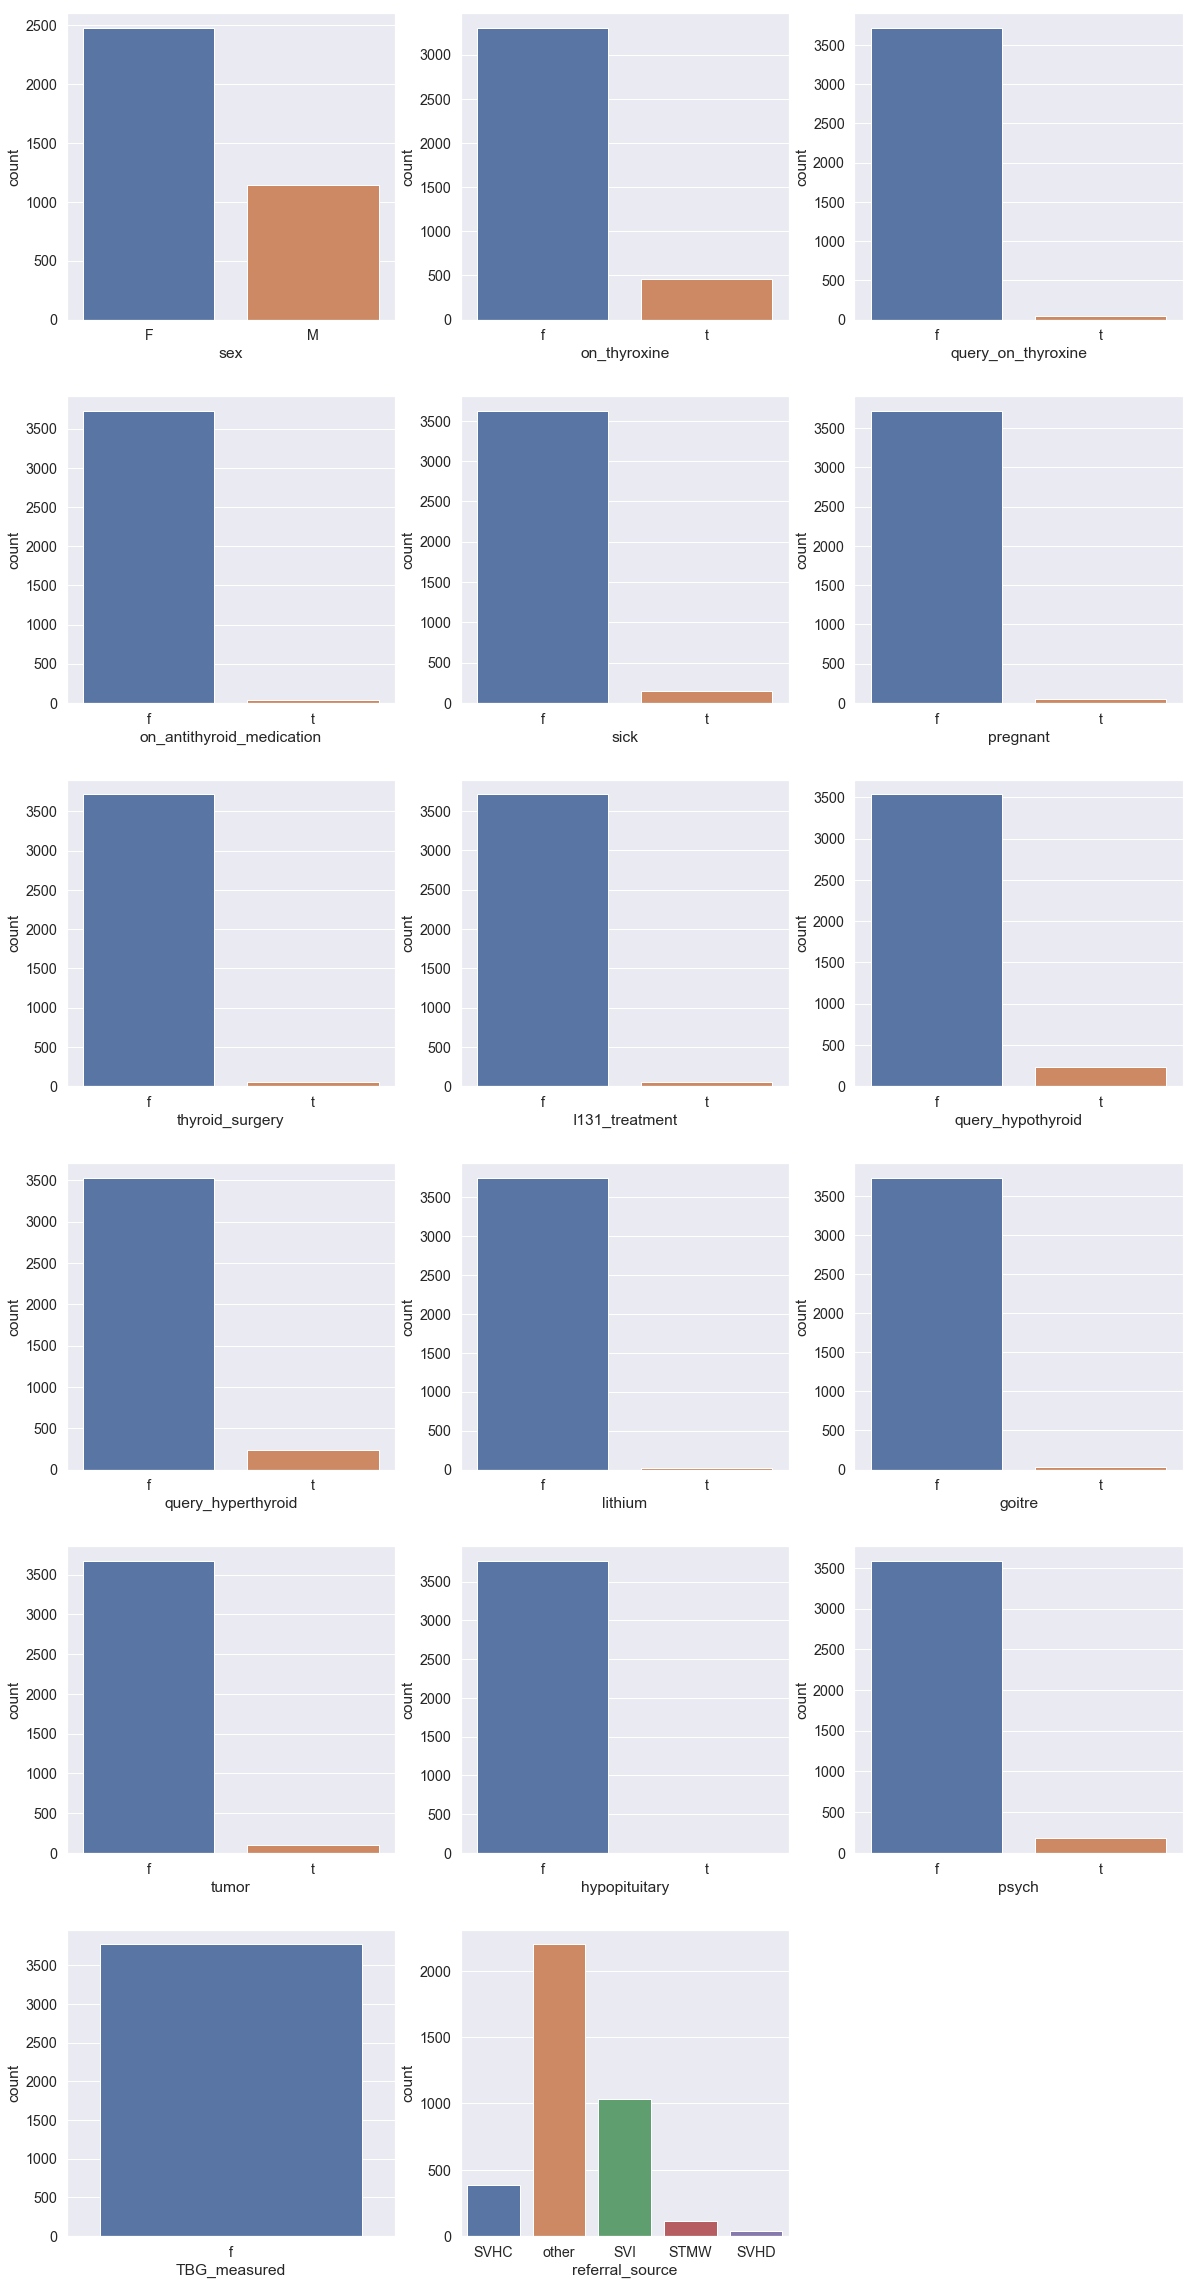

In [27]:
plt.figure(figsize=(20, 55)) 
for i, col in enumerate(df_cat.columns[:-1]):# выводим все величины, кроме последней (целевой, ее будем рассматривать отдельно)
    plt.subplot(8,3,i+1)
    sns.countplot(x=df_cat[col], data=df_cat)
    plt.subplots_adjust(hspace = 0.25)

Из графиков и таблицы можно сделать следующий вывод: 
- большинство классов несбалансированно.
- TBG_measured можно будет дропнуть, т.к. состоить только из одного значения.
- Стоит обратить внимание на признаки с thyroid в названии, возможно они могут привести к утечке данных.


In [28]:
df_cat.drop('TBG_measured', axis = 1, inplace=True)

E:\Python\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Анализ целевой переменной.

In [29]:
df_cat[target].value_counts()

negative                   3480
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

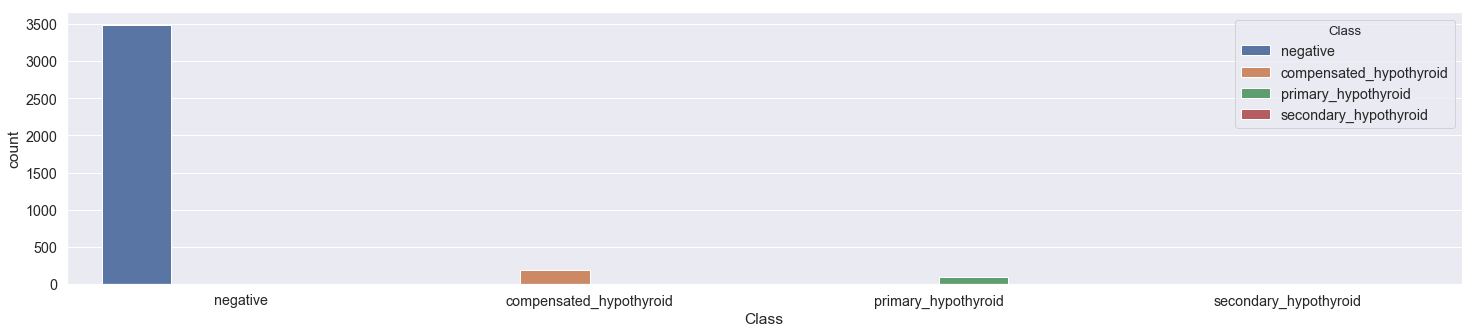

In [30]:
plt.figure(figsize=(25, 5))
sns.countplot(x=df_cat[target], hue='Class', data=df_cat)
plt.show()

Между классам достаточно большой разброс, на качество классификации это скорее всего повлияет отрицательно.

Посмотрим на зависимость других переменных от нашей целевой!

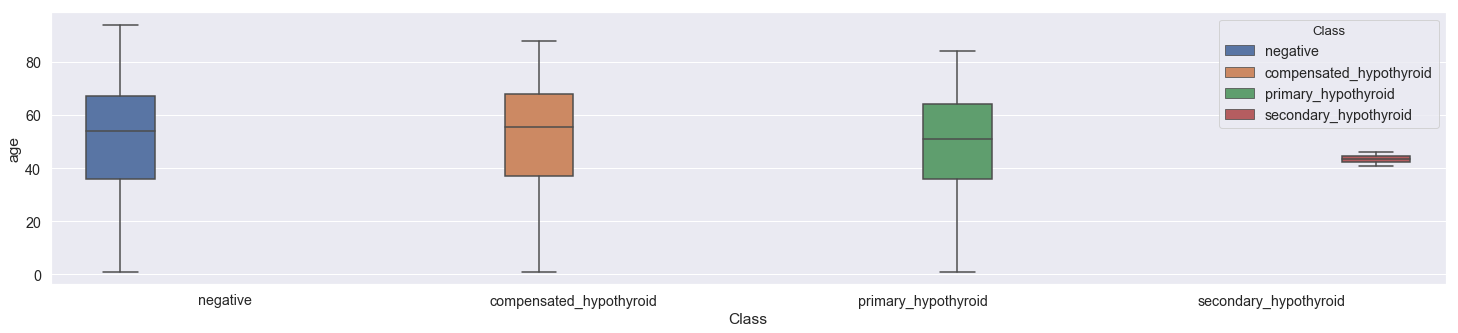

In [31]:
plt.figure(figsize=(25, 5))
sns.boxplot(x=df_cat[target],y=df_num.age, hue='Class', data=df_cat)
plt.show()

### Baseline models.

Разделим данные, включим стратификацию, потому, что классы несбалансированы.

In [32]:
y = df_cat[target]
X = pd.concat([df_num,df_cat.drop(target, axis=1)], axis=1, sort=False)

Производить enumerate над переменной класса не будем, т.к. это не имеет смысла в данной задаче.

In [33]:
# Binarize the output
#y = label_binarize(y, classes=['negative', 'compensated_hypothyroid', 'primary_hypothyroid', 'secondary_hypothyroid'])
#n_classes = y.shape[1]

In [34]:
n_classes = 4 # specify for plot function

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=seed, shuffle=True, stratify = y)

In [36]:
X_train.shape

(2639, 22)

In [37]:
X_test.shape

(1132, 22)

In [38]:
y_train.shape

(2639,)

In [39]:
y_test.shape

(1132,)

Настроим Pipeline для обработки данных и построения baseline-модели.

In [40]:
num_features = list(df_num).copy()
cat_ext = ['referral_source']
cat_bin = list(df_cat).copy()
cat_bin.remove('referral_source')
cat_bin.remove(target)

Для численных данных пропуски будем заполнять mean, скейлим как мин-макс и попробуем их привести к нормальному распределению.

In [41]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean',copy = False)),
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

In [42]:
cat_ext_features_pipeline = Pipeline([
    #('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')), 
    # здесь imputer не требуется т.к. пропусков нет в этой величине
    ('onehot', OneHotEncoder(categories =  [['SVHC', 'other', 'SVI', 'STMW', 'SVHD']],handle_unknown="ignore"))
])

Здесь используем category_encoders.BinaryEncoder потому, что он позволяет дропнуть полностью нулевые признаки.(drop_invariant=True)

In [43]:
cat_bin_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value='missing')),
    ('onehot', category_encoders.BinaryEncoder(drop_invariant=True,handle_unknown="ignore"))
])

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, num_features),
        ('cat_ext', cat_ext_features_pipeline, cat_ext),
        ('cat_bin', cat_bin_features_pipeline, cat_bin)
    ]
)

In [45]:
clf_log = OneVsRestClassifier(LogisticRegression(multi_class = 'multinomial',
                                                 solver='newton-cg',
                                                 random_state = seed,
                                                 n_jobs = -1,
                                                 max_iter = 10e2,
                                                 class_weight='balanced'))

In [46]:
baseline_pipeline_logit = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_log)
    ]
)

In [47]:
logit_regr = baseline_pipeline_logit.fit(X_train, y_train)

### Метрики.

Precision - здесь нужен, как оценка выявления правильно поставленного диагноза (т.е. считаем случаи, когда болен к отношению болен+болен ошибочно).

Recall - для выявления, что мы вычислили все случаи болезни и ничего не пропустили.

F1-score - комбинированная оценка, учитывающая предыдущие факторы. 

Здесь все перечисленные оценки будут полезны.

Посчитаем метрики для этого baseline'a.

In [154]:
y_pred_train = logit_regr.predict(X_train)
y_pred_test = logit_regr.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.70      0.93      0.80       136
               negative       1.00      0.98      0.99      2435
    primary_hypothyroid       0.76      0.82      0.79        67
  secondary_hypothyroid       0.50      1.00      0.67         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.74      0.93      0.81      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.74      0.97      0.84        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.69      0.71      0.70        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.97      0.97      0.97      1132
              macro avg       0.61      0.66      0.63      1132
   

Также зададим функцию для построение roc_auc.

In [49]:
# функция для построения roc_auc
def build_plot_roc_auc (n_classes,y_test,y_pred_test):
    y_test = label_binarize(y_test, classes=['negative', 
                                            'compensated_hypothyroid', 'primary_hypothyroid', 'secondary_hypothyroid'])
    y_pred_test = label_binarize(y_pred_test, classes=['negative', 
                                            'compensated_hypothyroid', 'primary_hypothyroid', 'secondary_hypothyroid'])
    #print (y_test)
    n_classes = 4
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(20,10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['blue', 'red', 'green','yellow'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

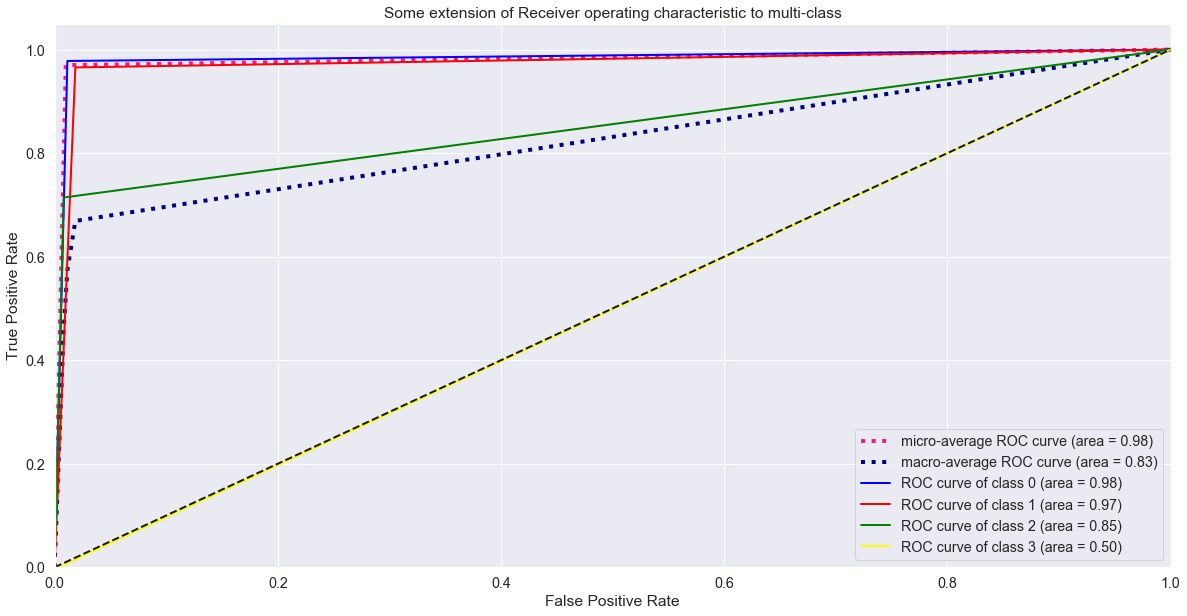

In [155]:
build_plot_roc_auc(n_classes, y_test,y_pred_test)

По результатам работы модели можно сказать, что:

- логистическая регрессия достаточно неплохо классифицировала объекты
- класс secondary_hypothyroid на тесте не распознался.
- primary_hypothyroid на тесте обладает также худшими результатами, чем на тесте.

Сделаем все, тоже самое для KNN.

In [51]:
clf_knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree',weights = 'uniform')
baseline_pipeline_knn = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_knn)
    ]
)

In [52]:
knn = baseline_pipeline_knn.fit(X_train, y_train)

In [53]:
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.91      0.72      0.80       136
               negative       0.98      1.00      0.99      2435
    primary_hypothyroid       0.94      0.91      0.92        67
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.98      0.98      0.98      2639
              macro avg       0.71      0.66      0.68      2639
           weighted avg       0.98      0.98      0.98      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.68      0.45      0.54        58
               negative       0.97      0.99      0.98      1045
    primary_hypothyroid       0.83      0.89      0.86        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.96      0.96      0.96      1132
              macro avg       0.62      0.58      0.60      1132
   

E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\

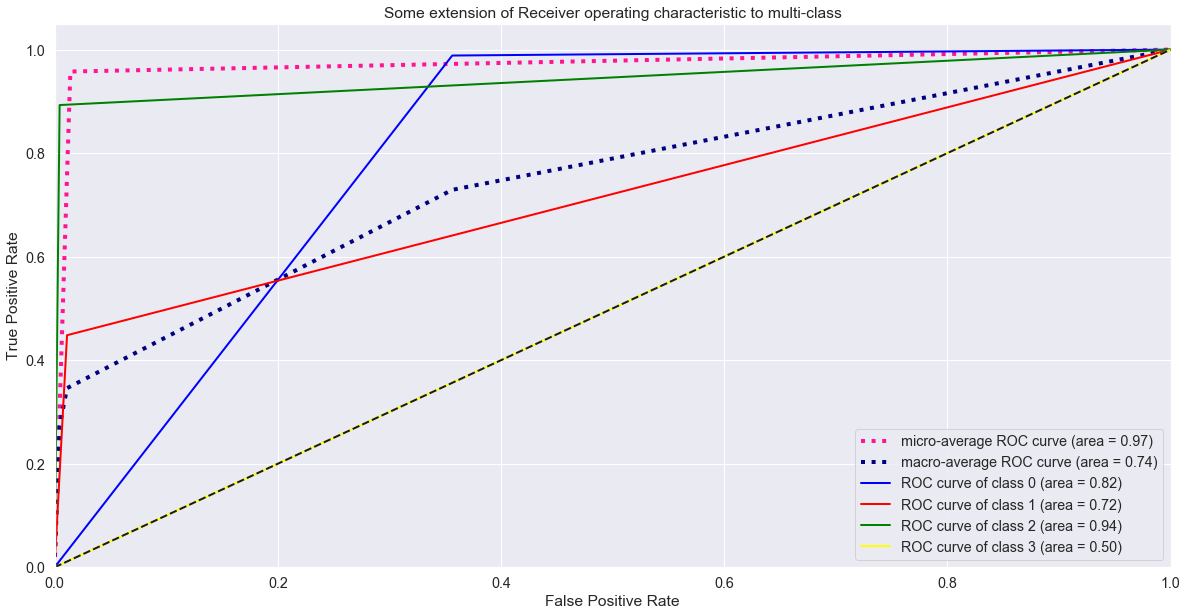

In [54]:
build_plot_roc_auc(n_classes, y_test,y_pred_test)

Вывод. Ситуация кардинально не изменилась.
compensated_hypothyroid стал распознаваться хуже, primary_hypothyroid стал распознаваться лучше.

Попробуем поработать с фичами и посмотрим как можно улучшить оценки.

В первую очередь попробуем что-нибудь сделать с диcбалансом в классах.

Для этого хорошо подходят следующие техники:

Oversampling.
- Суть данного метода заключается в добавлении объектов из класса, который "плохо представлен".

Undersampling:
- Суть данной техники заключается в удалении объектов доминирующего(-их) классов.

Undersampling в чистом виде здесь, как я думаю, не применим, основная проблема не в том, что какого-то класса слишком много, а в том, что одного класса (3) слишком мало.

Также данных в принципе не так много, поэтому удалять данные будет не лучшей идеей.

### Oversampling.



Остановимся на стратегии, которая задает принудительно количество объектов.

При стратегии auto, мы получаем равномерное количество объектов каждого класса, а это не хорошо, в силу того, что теряются изначальные пропорции датасета.

In [55]:
sampling_strategy = {'negative': 2435, 'compensated_hypothyroid': 200, 
                     'primary_hypothyroid': 140, 'secondary_hypothyroid': 20}
rovs = RandomOverSampler(random_state=seed,sampling_strategy=sampling_strategy)
#X_resampled, y_resampled = rovs.fit_resample(X_train,y_train)
#sampling_strategy = {0.25, 0.25,0.25,0.25}
#sampling_strategy = 'auto'
#sampling_strategy = 'all'
#X_resampled = pd.DataFrame(X_resampled)
#X_resampled.columns = (num_features + cat_bin + cat_ext)

In [56]:
pipeline = imb_mp(
    preprocessor,
    rovs,
    clf_log   
    )

In [57]:
logit_oversampled = pipeline.fit(X_train,y_train)

Посчитаем метрики для этого baseline'a.

In [58]:
y_pred_train = logit_oversampled.predict(X_train)
y_pred_test = logit_oversampled.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.73      0.92      0.81       136
               negative       1.00      0.98      0.99      2435
    primary_hypothyroid       0.70      0.88      0.78        67
  secondary_hypothyroid       0.17      1.00      0.29         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.65      0.94      0.72      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.75      0.93      0.83        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.62      0.75      0.68        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.97      0.97      0.97      1132
              macro avg       0.59      0.66      0.62      1132
   

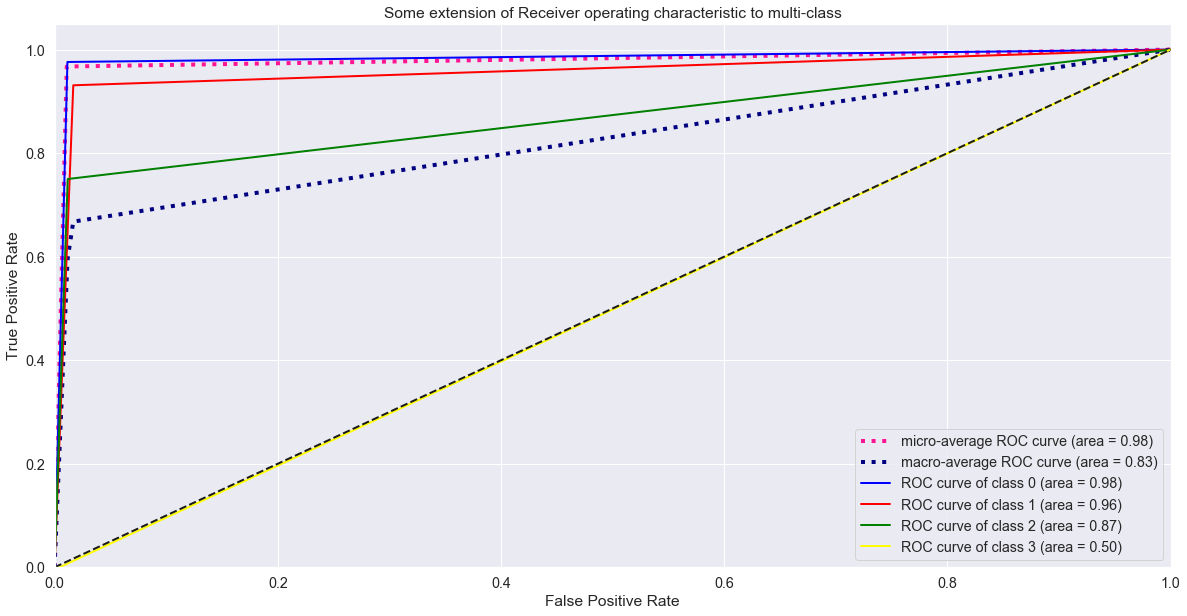

In [59]:
build_plot_roc_auc(n_classes, y_test,y_pred_test)

Классы compensated_hypothyroid, primary_hypothyroid стали распознаваться немного лучше.

Проверим полученную выборку в KNN.

In [60]:
pipeline_knn = imb_mp(
    preprocessor, 
    rovs,
    clf_knn   
    )

In [61]:
knn_oversampled = pipeline_knn.fit(X_train,y_train)

Посчитаем метрики для этого baseline'a.

In [62]:
y_pred_train = knn_oversampled.predict(X_train)
y_pred_test = knn_oversampled.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.86      0.79      0.83       136
               negative       0.99      0.99      0.99      2435
    primary_hypothyroid       0.96      0.96      0.96        67
  secondary_hypothyroid       0.50      1.00      0.67         1

              micro avg       0.98      0.98      0.98      2639
              macro avg       0.83      0.94      0.86      2639
           weighted avg       0.98      0.98      0.98      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.56      0.53      0.55        58
               negative       0.98      0.98      0.98      1045
    primary_hypothyroid       0.77      0.82      0.79        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.95      0.95      0.95      1132
              macro avg       0.58      0.58      0.58      1132
   

E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


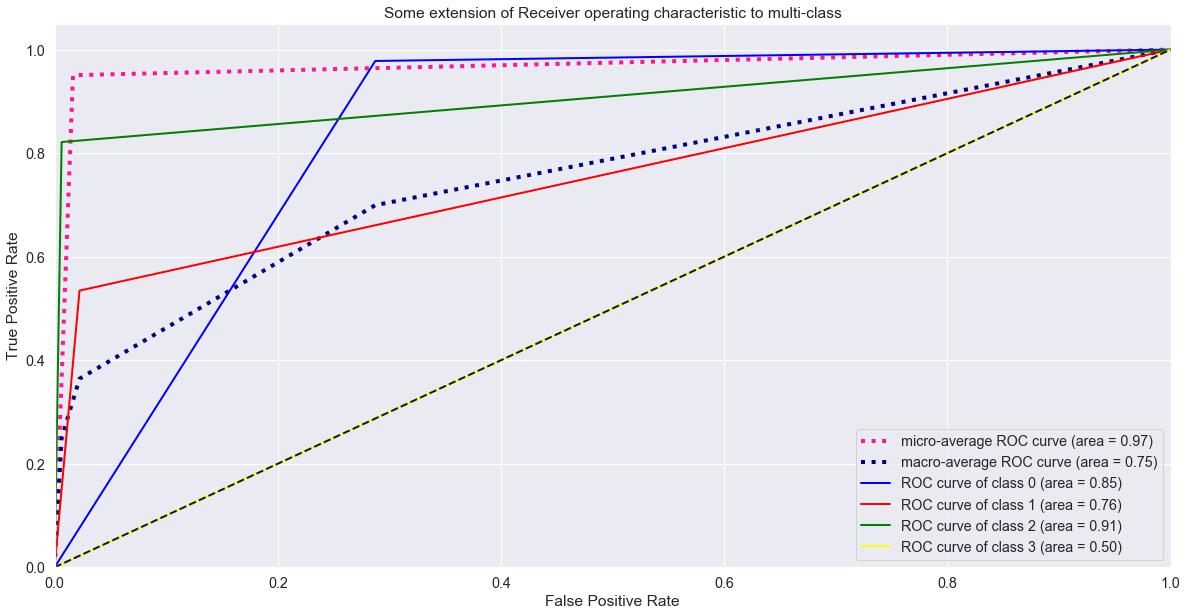

In [63]:
build_plot_roc_auc(n_classes, y_test,y_pred_test)

Для KNN по сравнению с baseline моделью оценки стали немного хуже, из чего можно сделать вывод, что оверсемпл плохо работает. Исходя из теории это подтверждается фактом. 

### Feature processing.

Попробуем выделить признаки, оказывающие наибольшее влияние на работу алгоритмов.

Для этого сохраним dummy-признаки, которые получаются после encoding'а в pipeline, чтобы было легче идентифицировать веса в дальнейшем.

In [64]:
bin_names = ['sex_1', 'sex_2', 'on_thyroxine_0', 'on_thyroxine_1',
       'query_on_thyroxine_0', 'query_on_thyroxine_1',
       'on_antithyroid_medication_0', 'on_antithyroid_medication_1', 'sick_0',
       'sick_1', 'pregnant_0', 'pregnant_1', 'thyroid_surgery_0',
       'thyroid_surgery_1', 'I131_treatment_0', 'I131_treatment_1',
       'query_hypothyroid_0', 'query_hypothyroid_1', 'query_hyperthyroid_0',
       'query_hyperthyroid_1', 'lithium_0', 'lithium_1', 'goitre_0',
       'goitre_1', 'tumor_0', 'tumor_1', 'hypopituitary_0', 'hypopituitary_1',
       'psych_0', 'psych_1']

ext_names = ['SVHC', 'other', 'SVI', 'STMW', 'SVHD']

In [65]:
len (num_features  + ext_names + bin_names)

41

Зададим параметры для регрессии с l1-регуляризацей.

In [66]:
clf_log_l1 = OneVsRestClassifier(LogisticRegression(penalty='l1',
                                                 solver = 'liblinear',
                                                 C=0.5,
                                                 random_state = seed,
                                                 n_jobs = -1,
                                                 max_iter = 10e2,
                                                 class_weight='balanced'))

In [67]:
pipeline_l1 = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_log_l1)
    ]
)

In [68]:
logit_regr_l1 = pipeline_l1.fit(X_train, y_train)

Посчитаем метрики.

In [69]:
y_pred_train = logit_regr_l1.predict(X_train)
y_pred_test = logit_regr_l1.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.66      0.97      0.79       136
               negative       1.00      0.98      0.99      2435
    primary_hypothyroid       0.72      0.63      0.67        67
  secondary_hypothyroid       0.25      1.00      0.40         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.66      0.89      0.71      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.71      0.97      0.82        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.63      0.61      0.62        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.97      0.97      0.97      1132
              macro avg       0.58      0.64      0.61      1132
   

Результаты работы модели весьма неплохие.

По сравнению с baseline выросли хар-ки точности и полноты для классов compensated_hypothyroid, primary_hypothyroid.

Так как lasso регуляризатор характерен отбором признаков, посмотрим коэффициенты для этой модели.

In [70]:
coefs = logit_regr_l1.steps[1][1].coef_

In [71]:
coefs = pd.DataFrame(np.abs(coefs), columns = (num_features  + ext_names + bin_names))

Выберем такие коэффициенты которые неотрицательны и несколько больше нуля.

In [72]:
coefs[coefs > 0.1].T

,0,1,2,3
age,NaN,NaN,0.596655,0.577923
TSH,6.328951,9.752791,4.324249,0.692166
T3,0.431968,0.513903,0.179504,0.859106
TT4,0.545072,NaN,1.161996,0.383777
T4U,0.339063,NaN,0.120711,3.131162
FTI,NaN,0.717740,1.191900,5.625527
SVHC,NaN,NaN,0.182536,NaN
other,0.582441,0.241735,1.843546,1.738388
SVI,NaN,NaN,NaN,5.237143
STMW,0.307587,NaN,2.059514,NaN


Это такие признаки как:
'age','TSH','T3','TT4','T4U','FTI',
'refferal_source',
'sex','on_thyroxine','on_antithyroid_medication',
'sick','thyroid_surgery',
'query_hypothyroid','query_hyperthyroid',
'I131_treatment',,'hypopituitary','psych'

Зная признаки, обладающие наибольшим влиянием на классификацию, попробуем в дальнейшем их использовать для подбора гиперпараметров.

Сейчас попробуем их проверить при работе в baseline.

In [73]:
X_train_1 = X_train[['age','TSH','T3','TT4','T4U','FTI',
                    'referral_source', 'sex','on_thyroxine','on_antithyroid_medication', 
                    'sick','thyroid_surgery', 'query_hypothyroid',
                    'query_hyperthyroid', 'I131_treatment','hypopituitary','psych']]

X_test_1 = X_test[['age','TSH','T3','TT4','T4U','FTI',
                    'referral_source', 'sex','on_thyroxine','on_antithyroid_medication', 
                    'sick','thyroid_surgery', 'query_hypothyroid',
                    'query_hyperthyroid', 'I131_treatment','hypopituitary','psych']]

In [74]:
num_features_f = list(df_num).copy()
cat_ext_f = ['referral_source']
cat_bin_f = list(df_cat).copy()
cat_bin_f.remove('referral_source')
cat_bin_f.remove(target)
cat_bin_f.remove('query_on_thyroxine')
cat_bin_f.remove('pregnant')
cat_bin_f.remove('lithium')
cat_bin_f.remove('goitre')
cat_bin_f.remove('tumor')

In [75]:
preprocessor_imp_f = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, num_features_f),
        ('cat_ext', cat_ext_features_pipeline, cat_ext_f),
        ('cat_bin', cat_bin_features_pipeline, cat_bin_f)
    ]
)

In [76]:
pipeline_imp_f = Pipeline(
    steps=[
        ('preprocessing', preprocessor_imp_f),
        ('classify', clf_log)
    ]
)

In [77]:
logit_regr_imp_f = pipeline_imp_f.fit(X_train_1, y_train)

Посчитаем метрики для этого baseline'a.

In [78]:
y_pred_train = logit_regr_imp_f.predict(X_train_1)
y_pred_test = logit_regr_imp_f.predict(X_test_1)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.68      0.95      0.79       136
               negative       1.00      0.98      0.99      2435
    primary_hypothyroid       0.74      0.73      0.74        67
  secondary_hypothyroid       0.20      1.00      0.33         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.66      0.91      0.71      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.72      0.97      0.82        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.64      0.64      0.64        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.97      0.97      0.97      1132
              macro avg       0.59      0.65      0.61      1132
   

Альтернативным вариант, можно попробовать избавиться от всех признаков, имеющих в названии thyroid, подразумевая их всмысле признаков, которые впрямую могут подсказать, что такое заболевание присутствует.

In [79]:
X_train_2 = X_train[['age','TSH','T3','TT4','T4U','FTI',
                    'referral_source', 'sex', 'pregnant', 'lithium','goitre','tumor',
                    'sick', 'I131_treatment','hypopituitary','psych']]

X_test_2 = X_test[['age','TSH','T3','TT4','T4U','FTI',
                    'referral_source', 'sex', 'pregnant', 'lithium','goitre','tumor',
                    'sick', 'I131_treatment','hypopituitary','psych']]

In [80]:
num_features_f1 = list(df_num).copy()
cat_ext_f1 = ['referral_source']
cat_bin_f1 = list(df_cat).copy()
cat_bin_f1.remove('referral_source')
cat_bin_f1.remove(target)
cat_bin_f1.remove('query_on_thyroxine')
cat_bin_f1.remove('on_thyroxine')
cat_bin_f1.remove('on_antithyroid_medication')
cat_bin_f1.remove('thyroid_surgery')
cat_bin_f1.remove('query_hypothyroid')
cat_bin_f1.remove('query_hyperthyroid')

In [81]:
preprocessor_imp_f1 = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, num_features_f1),
        ('cat_ext', cat_ext_features_pipeline, cat_ext_f1),
        ('cat_bin', cat_bin_features_pipeline, cat_bin_f1)
    ]
)

In [82]:
pipeline_imp_f1 = Pipeline(
    steps=[
        ('preprocessing', preprocessor_imp_f1),
        ('classify', clf_log)
    ]
)

In [83]:
logit_regr_imp_f1 = pipeline_imp_f1.fit(X_train_2, y_train)

Посчитаем метрики для этого baseline'a.

In [84]:
y_pred_train = logit_regr_imp_f1.predict(X_train_2)
y_pred_test = logit_regr_imp_f1.predict(X_test_2)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.54      0.93      0.68       136
               negative       1.00      0.96      0.98      2435
    primary_hypothyroid       0.82      0.73      0.77        67
  secondary_hypothyroid       0.20      1.00      0.33         1

              micro avg       0.95      0.95      0.95      2639
              macro avg       0.64      0.91      0.69      2639
           weighted avg       0.97      0.95      0.96      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.62      0.97      0.75        58
               negative       1.00      0.96      0.98      1045
    primary_hypothyroid       0.69      0.71      0.70        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.96      0.96      0.96      1132
              macro avg       0.58      0.66      0.61      1132
   

Как видно из таблицы, оценки для primary_hypothyroid существенно выросли по сравнению с baseline, для compensated_hypothyroid оценки наоборот немного упали.

Также проверим работу алгоритма регрессии удалив несколько коррелирующих между собой численных признаков(T3 и FTI коррелируют с TT4) при помощи Function Transformer. 

In [85]:
def drop_corr_features(df_drop):
    return np.delete(df_drop, [2,5], axis=1)

In [86]:
pipeline_dropped = imb_mp(
    preprocessor,
    FunctionTransformer(drop_corr_features),
    clf_log    
    )

In [87]:
dropped_features_pipeline = pipeline_dropped.fit(X_train, y_train) 

E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [88]:
y_pred_train = dropped_features_pipeline.predict(X_train)
y_pred_test = dropped_features_pipeline.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.69      0.94      0.80       136
               negative       1.00      0.98      0.99      2435
    primary_hypothyroid       0.69      0.70      0.70        67
  secondary_hypothyroid       0.14      1.00      0.25         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.63      0.90      0.68      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.72      0.97      0.82        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.59      0.57      0.58        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.96      0.96      0.96      1132
              macro avg       0.58      0.63      0.60      1132
   

E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Оценки для primary_hypothyroid стали чуть хуже, тогда как для compensated_hypothyroid немного выросли.

В целом, изменение незначительное.

KNN с удаленными признаками.

In [89]:
pipeline_dropped_knn = imb_mp(
    preprocessor,
    FunctionTransformer(drop_corr_features),
    clf_log    
    )

In [90]:
dropped_features_pipeline_knn = pipeline_dropped_knn.fit(X_train, y_train) 

E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [91]:
y_pred_train = dropped_features_pipeline_knn.predict(X_train)
y_pred_test = dropped_features_pipeline_knn.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.69      0.94      0.80       136
               negative       1.00      0.98      0.99      2435
    primary_hypothyroid       0.69      0.70      0.70        67
  secondary_hypothyroid       0.14      1.00      0.25         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.63      0.90      0.68      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.72      0.97      0.82        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.59      0.57      0.58        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.96      0.96      0.96      1132
              macro avg       0.58      0.63      0.60      1132
   

E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
E:\Python\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Оценки для primary_hypothyroid "поменялись" местами с compensated_hypothyroid, похоже, с удалением численных признаков теряется способность классификации.

### Регуляризация.

Попробуем подобрать параметры регуляризации.

Т.к. данные несбалансированы то наилучшим выходом будет использование разбиения StratifiedKfold при кросс-валидации.

In [92]:
pipeline_search_logit = imb_mp(
    preprocessor,
    clf_log    
    )

In [93]:
my_scorer = make_scorer(f1_score, average='weighted')
skv = StratifiedKFold(n_splits = 5,random_state=seed, shuffle=False)

Для поиска наилучших параметров подадим на вход несколько различных значений параметра регуляризации, а также различных солверов.

In [94]:
%%time

tuned_parameters = [{
    'onevsrestclassifier__estimator__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50],
    'onevsrestclassifier__estimator__solver': ['newton-cg','lbfgs']
                    }]


bclf = GridSearchCV(pipeline_search_logit, tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1,refit='roc_auc')

bclf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


E:\Python\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.2s finished


Wall time: 44.5 s


In [95]:
bclf.best_params_

{'onevsrestclassifier__estimator__C': 20,
 'onevsrestclassifier__estimator__solver': 'newton-cg'}

In [96]:
pipeline_search_logit.set_params(onevsrestclassifier__estimator__C = 10, 
                                 onevsrestclassifier__estimator__solver = 'newton-cg')

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', ve...10, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False),
          n_jobs=None))])

In [97]:
log_with_best_params = pipeline_search_logit.fit(X_train, y_train)

Посчитаем метрики для этого baseline'a.

In [98]:
y_pred_train = log_with_best_params.predict(X_train)
y_pred_test = log_with_best_params.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.70      0.93      0.80       136
               negative       1.00      0.98      0.99      2435
    primary_hypothyroid       0.76      0.82      0.79        67
  secondary_hypothyroid       0.50      1.00      0.67         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.74      0.93      0.81      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.74      0.97      0.84        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.69      0.71      0.70        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.97      0.97      0.97      1132
              macro avg       0.61      0.66      0.63      1132
   

Дополнительно, был произведен поиск наилучших параметров с фичами, полученными при помощи регуляризации Lasso, а также  без фич, характеризующих заболевание. Код однотипный, его не стал дублировать, результаты отдельно сохранил.

logit cv (features as is)

               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.71      0.71      0.71        28
    secondary_hypothyroid     0.00      0.00      0.00         1 
    compensated_hypothyroid   0.73      0.97      0.83        58
  
with lasso features

               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.71      0.71      0.71        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.73      0.97      0.83        58
  
without thyroid

               negative       1.00      0.96      0.98      1045
    primary_hypothyroid       0.70      0.75      0.72        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.62      0.97      0.75        58

Хочется отметить, что в последнем случае для primary_hypothyroid выросла полнота, что достаточно важно при диагностике заболевания.

Для простой логистической регрессии/наилучших фич - результат схожий.

Попробуем также подобрать наилучшие параметры для KNN.

In [99]:
pipeline_search_knn= imb_mp(
    preprocessor_imp_f1,
    clf_knn    
    )

In [100]:
my_scorer = make_scorer(f1_score, average='weighted')
skv = StratifiedKFold(n_splits = 5,random_state=seed, shuffle=False)

Количество соседей выставляем таким образом, чтобы это были в основном нечетные числа.

In [101]:
values = np.linspace(1, 200, 100).astype(int)

Искать наилучшие параметры будем среди числа соседей и типов весов, алгоритмом поиска лучших соседей.
Так как алгоритм поиска наилучших параметров для KNN весьма трудоемкий, то вместо GridSearchCV будем использовать RandomizedSearchCV.


In [102]:
%%time

tuned_parameters = dict(kneighborsclassifier__n_neighbors= values,
                     kneighborsclassifier__weights= ['uniform', 'distance'],
                     kneighborsclassifier__algorithm=['kd_tree','ball_tree']
                       )
# inverse = 1/

kclf = RandomizedSearchCV(pipeline_search_knn, param_distributions = tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1, n_iter = 40)

kclf.fit(X_train_2, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


E:\Python\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   51.4s finished


Wall time: 51.8 s


In [103]:
kclf.best_params_

{'kneighborsclassifier__weights': 'distance',
 'kneighborsclassifier__n_neighbors': 3,
 'kneighborsclassifier__algorithm': 'ball_tree'}

In [104]:
baseline_pipeline_knn.set_params(classify__n_neighbors = 5, 
                                 classify__weights = 'distance',
                                 classify__algorithm = 'kd_tree')

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbos...i',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance'))])

In [105]:
knn_with_best_params = pipeline_search_knn.fit(X_train_2, y_train)

In [106]:
y_pred_train = knn_with_best_params.predict(X_train_2)
y_pred_test = knn_with_best_params.predict(X_test_2)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       1.00      1.00      1.00       136
               negative       1.00      1.00      1.00      2435
    primary_hypothyroid       1.00      1.00      1.00        67
  secondary_hypothyroid       1.00      1.00      1.00         1

              micro avg       1.00      1.00      1.00      2639
              macro avg       1.00      1.00      1.00      2639
           weighted avg       1.00      1.00      1.00      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.64      0.31      0.42        58
               negative       0.96      0.99      0.98      1045
    primary_hypothyroid       0.80      0.86      0.83        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.95      0.95      0.95      1132
              macro avg       0.60      0.54      0.56      1132
   

E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Дополнительно, был произведен поиск наилучших параметров с фичами, полученными при помощи регуляризации Lasso, а также  без фич, характеризующих заболевание. Код однотипный, его не стал дублировать, результаты отдельно сохранил.

knn cv (feature as is)

                        precision    recall  f1-score   support
               negative       0.97      0.99      0.98      1045
    primary_hypothyroid       0.82      0.82      0.82        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.71      0.38      0.49        58
  
with lasso features

               negative       0.97      0.99      0.98      1045
    primary_hypothyroid       0.80      0.86      0.83        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.69      0.43      0.53        58
  
without thyroid

               negative       0.96      0.99      0.98      1045
    primary_hypothyroid       0.80      0.86      0.83        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.64      0.31      0.42        58

Вывод по KNN.

Все полученные оценки с регуляризацией оказались хуже чем baseline модель.

Вывод.

Среди сравненных классфикаторов и параметров наилучшими оценками обладают:
- логистическая регрессия с кросс-валидацией (все фичи в датасете)
- логистическая регрессия с кросс-валидацией (без *thyroid-фич)
- knn с оверспемплированием.

logit cv (features as is)     
    
                        precision    recall  f1-score   support
    negative                  1.00      0.98      0.99      1045
    primary_hypothyroid       0.71      0.71      0.71        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.73      0.97      0.83        58
  
logit without thyroid

               negative       1.00      0.96      0.98      1045
    primary_hypothyroid       0.70      0.75      0.72        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.62      0.97      0.75        58

knn with ovs    

               negative       0.98      0.98      0.98      1045
    primary_hypothyroid       0.77      0.82      0.79        28
    secondary_hypothyroid     0.00      0.00      0.00         1
    compensated_hypothyroid   0.56      0.53      0.55        58

Для случая, если мы хотим характеризовать полноту наилучшим образом, то KNN с RandomOverSampler подойдет лучше всего.

Если же речь идет о оценке F-score и precision то логистрическая регрессия здесь показывает себя лучше.

#### SVC TEST.

In [107]:
from sklearn.svm import SVC

In [108]:
#y_train = y_train[y_train != 'secondary_hypothyroid']
#y_test = y_test[y_test != 'secondary_hypothyroid']

In [137]:
svc = OneVsRestClassifier(SVC(kernel = 'rbf',
                              gamma = 'scale',
                              random_state = seed,
                              decision_function_shape = 'ovr',
                              class_weight = 'balanced',
                              probability = True
                             ))

In [138]:
baseline_svc = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', svc)
    ]
)

In [111]:
svc_classif = baseline_svc.fit(X_train, y_train)

In [112]:
y_pred_train = svc_classif.predict(X_train)
y_pred_test = svc_classif.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.67      0.99      0.80       136
               negative       1.00      0.97      0.99      2435
    primary_hypothyroid       0.91      0.90      0.90        67
  secondary_hypothyroid       1.00      1.00      1.00         1

              micro avg       0.97      0.97      0.97      2639
              macro avg       0.89      0.97      0.92      2639
           weighted avg       0.98      0.97      0.97      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.73      0.98      0.84        58
               negative       1.00      0.98      0.99      1045
    primary_hypothyroid       0.72      0.82      0.77        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.97      0.97      0.97      1132
              macro avg       0.61      0.70      0.65      1132
   

E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [180]:
tuned_parameters = [
    {
    'classify__estimator__kernel': ['poly'],
    'classify__estimator__degree': [1, 2, 3, 4],
    'classify__estimator__coef0': [0.1, 0.5, 1, 5, 10, 20, 40, 50],
    'classify__estimator__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50]
                    },
    {
    'classify__estimator__kernel': ['rbf'],
    'classify__estimator__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50],
    'classify__estimator__gamma': [0.001,0.01, 0.05, 0.1, 0.5, 1]
                    },
    {
    'classify__estimator__kernel': [ 'sigmoid'],
    'classify__estimator__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50],
    'classify__estimator__coef0': [0.1, 0.5, 1, 5, 10, 20, 40, 50]
                    },
    {
    'classify__estimator__kernel': [ 'linear'],
    'classify__estimator__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50]
                    }

]


bsvc = GridSearchCV(baseline_svc, tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=2, n_jobs=-1,refit='roc_auc')


In [181]:
#bsvc.get_params().keys()

In [182]:
#for key in bsvc.get_params().keys():
#    print(key)

In [183]:
%%time
bsvc.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


E:\Python\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 36.0min finished
E:\Python\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will cha

Wall time: 36min 1s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbos...ability=True, random_state=10, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'classify__estimator__kernel': ['poly'], 'classify__estimator__degree': [1, 2, 3, 4], 'classify__estimator__coef0': [0.1, 0.5, 1, 5, 10, 20, 40, 50], 'classify__estimator__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50]}, {'classify__estimator__kernel': ['rbf'], 'classify__estimator__C...mator__kernel': ['linear'], 'classify__estimator__C': [0.01, 0.05, 0.1, 0.5,

In [184]:
bsvc.best_params_

{'classify__estimator__C': 0.5,
 'classify__estimator__coef0': 10,
 'classify__estimator__degree': 4,
 'classify__estimator__kernel': 'poly'}

In [188]:
baseline_svc.set_params(classify__estimator__C = 0.5,
                        classify__estimator__coef0 = 10,
                        classify__estimator__degree = 4,
                       classify__estimator__kernel = 'poly')

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbos...ability=True, random_state=10, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None))])

In [189]:
svc_with_best_params = baseline_svc.fit(X_train, y_train)

Посчитаем метрики для этого baseline'a.

In [190]:
y_pred_train = svc_with_best_params.predict(X_train)
y_pred_test = svc_with_best_params.predict(X_test)
print ("on train")
print(classification_report(y_train, y_pred_train))
print ("on test")
print(classification_report(y_test, y_pred_test))

on train
                         precision    recall  f1-score   support

compensated_hypothyroid       0.94      1.00      0.97       136
               negative       1.00      1.00      1.00      2435
    primary_hypothyroid       1.00      0.99      0.99        67
  secondary_hypothyroid       1.00      1.00      1.00         1

              micro avg       1.00      1.00      1.00      2639
              macro avg       0.98      1.00      0.99      2639
           weighted avg       1.00      1.00      1.00      2639

on test
                         precision    recall  f1-score   support

compensated_hypothyroid       0.77      0.88      0.82        58
               negative       0.99      0.98      0.99      1045
    primary_hypothyroid       0.71      0.79      0.75        28
  secondary_hypothyroid       0.00      0.00      0.00         1

              micro avg       0.97      0.97      0.97      1132
              macro avg       0.62      0.66      0.64      1132
   

E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


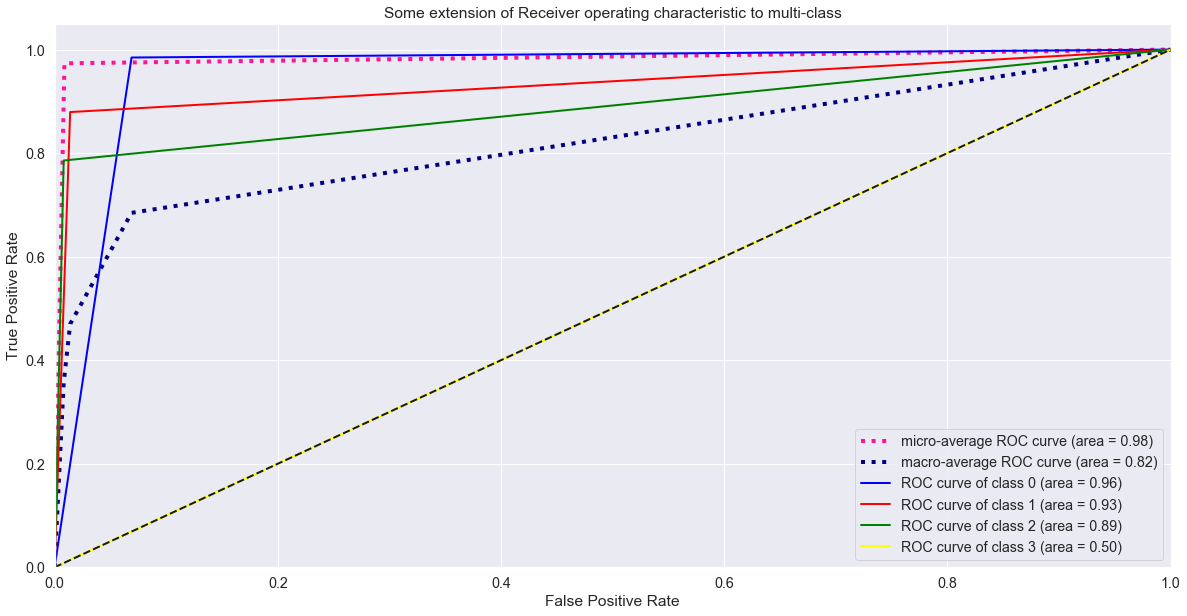

In [191]:
build_plot_roc_auc(n_classes, y_test,y_pred_test)

In [157]:
y_pred_train = svc_with_best_params.predict_proba(X_train)
y_pred_test = svc_with_best_params.predict_proba(X_test)

In [192]:
y_test_for = [0, 0, 0, 1, 1, 1, 0]
y_prob = np.array([0.5, 0.1, 0.2, 0.6, 0.2, 0.3, 0.0])

In [193]:
fpr, tpr, _ = roc_curve(y_test_for, y_prob)

In [194]:
auc(fpr, tpr)

0.7916666666666666

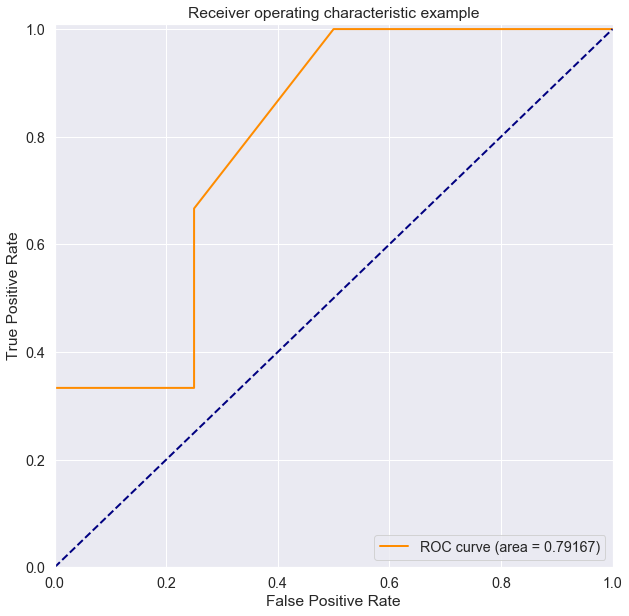

In [195]:
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [196]:
roc_auc_score(y_test_for, y_prob) 

0.7916666666666666

In [ ]:
print test

### Appendix.

Еще одним способом улучшить размерность может стать SVD.

In [124]:
n_comp =X_train.shape[1] - 1

svd_model = TruncatedSVD(n_components=n_comp, 
                         algorithm='randomized',
                         n_iter=10, random_state=seed)

In [125]:
simp = SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value='missing')

In [126]:
df[df.duplicated()]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
204,26.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
210,64.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
303,22.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
431,58.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
717,40.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
820,41.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
846,26.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
925,58.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
1017,57.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
1047,57.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative


In [127]:
#all_features_transformed_logit.steps[1][1].coef_

In [128]:
"""clfs = []
clfs.append(LogisticRegression())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs
baseline_pipeline.set_params(clf = classifier)"""

'clfs = []\nclfs.append(LogisticRegression())\nclfs.append(KNeighborsClassifier(n_neighbors=3))\nclfs\nbaseline_pipeline.set_params(clf = classifier)'

In [129]:
means = kclf.cv_results_['mean_test_score']
stds = kclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, kclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


0.927 (+/-0.011) for {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__algorithm': 'ball_tree'}
0.908 (+/-0.007) for {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__n_neighbors': 91, 'kneighborsclassifier__algorithm': 'kd_tree'}
0.923 (+/-0.008) for {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 47, 'kneighborsclassifier__algorithm': 'ball_tree'}
0.930 (+/-0.014) for {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__algorithm': 'kd_tree'}
0.909 (+/-0.006) for {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 107, 'kneighborsclassifier__algorithm': 'kd_tree'}
0.897 (+/-0.013) for {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__n_neighbors': 117, 'kneighborsclassifier__algorithm': 'kd_tree'}
0.940 (+/-0.019) for {'kneighborsclassifier__weights': 'distance', 'kneig

In [130]:
pipeline_search_logit.steps

[('columntransformer',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('num', Pipeline(memory=None,
       steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
         strategy='mean', verbose=0)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('transform', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n...'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych'])])),
 ('onevsrestclassifier',
  OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=1000.0,
            multi_class='multinomial', n_jobs=-1, penalty='l2',
            random_state=10, solver='newton-cg', tol=0.0001, verbose=0,
            warm_start=False),
            n_jobs=None))]

In [131]:
for key in kclf.get_params().values():
    print(key)

StratifiedKFold(n_splits=5, random_state=10, shuffle=False)
raise-deprecating
None
[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('transform', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n...ex', 'sick', 'pregnant', 'I131_treatment', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych'])])), ('kneighborsclassifier', KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance'))]
ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('i

In [132]:
bclf.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__columntransformer', 'estimator__onevsrestclassifier', 'estimator__columntransformer__n_jobs', 'estimator__columntransformer__remainder', 'estimator__columntransformer__sparse_threshold', 'estimator__columntransformer__transformer_weights', 'estimator__columntransformer__transformers', 'estimator__columntransformer__num', 'estimator__columntransformer__cat_ext', 'estimator__columntransformer__cat_bin', 'estimator__columntransformer__num__memory', 'estimator__columntransformer__num__steps', 'estimator__columntransformer__num__impute', 'estimator__columntransformer__num__scale', 'estimator__columntransformer__num__transform', 'estimator__columntransformer__num__impute__copy', 'estimator__columntransformer__num__impute__fill_value', 'estimator__columntransformer__num__impute__missing_values', 'estimator__columntransformer__num__impute__strategy', 'estimator__columntransformer__num__impute__verbose', 'estim

In [133]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')

def ratio_multiplier(y):
    multiplier = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    target_stats = Counter(y)
    for key, value in target_stats.items():
        if key in multiplier:
            target_stats[key] = int(value * multiplier[key])
    return target_stats

In [134]:
ff =  pd.DataFrame(pd.DataFrame(y_resampled))
tt = ratio_multiplier(ff)
tt

NameError: name 'y_resampled' is not defined

In [ ]:
"""a = np.linspace(7, 26, num=21).astype(int)

encoded = ohc.fit_transform(X)
ros = SMOTENC(random_state=seed,categorical_features=[7, 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 26])
X_resampled, y_resampled = ros.fit_resample(X, y)"""

In [ ]:
y_for_count = pd.DataFrame(y)
for i, col in enumerate(y_for_count.columns):
    print(y_for_count[col].value_counts())

In [ ]:
y_resampled_for_count = pd.DataFrame(y_resampled)
for i, col in enumerate(y_resampled_for_count.columns):
    print(y_resampled_for_count[col].value_counts())